In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
#base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
import seaborn as sns

#preprocess
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from collections import  Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

#wordcloud
from wordcloud import WordCloud, STOPWORDS

#stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

#embedding
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Embedding, Dense, Flatten, Input, BatchNormalization, GlobalAveragePooling1D, AveragePooling1D, Bidirectional, LSTM, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model, to_categorical

from sklearn.metrics import accuracy_score, log_loss

# col 생략 없이 출력
pd.set_option('display.max_columns', None)
# col 최대 너비 200
pd.set_option('max_colwidth', 200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')

1 Physical GPUs, 1 Logical GPU


In [4]:
train = pd.read_csv('/content/drive/MyDrive/clean_train.csv',index_col=0)
test = pd.read_csv('/content/drive/MyDrive/clean_test.csv',index_col=0)
train.head()

,clean_text,author
index,,
0,he was almost choking there was so much so much he wanted to say but strange exclamations were all that came from his lips the pole gazed fixedly at him at the bundle of notes in his hand looked a...,3
1,your sister asked for it i suppose,2
2,she was engaged one day as she walked in perusing janes last letter and dwelling on some passages which proved that jane had not written in spirits when instead of being again surprised by mr odin...,1
3,the captain was in the porch keeping himself carefully out of the way of a treacherous shot should any be intended he turned and spoke to us doctors watch on the lookout dr odin take the north sid...,4
4,have mercy gentlemen odin flung up his hands dont write that anyway have some shame here ive torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both hal...,3


In [5]:
X_train = np.array([x for x in train['clean_text']])
X_test = np.array([x for x in test['clean_text']])
Y_train = np.array([x for x in train['author']])

In [6]:
train['clean_text'].str.len().describe()

count    54835.000000
mean       218.017744
std        268.786526
min          9.000000
25%         58.000000
50%        111.000000
75%        254.000000
max       2442.000000
Name: clean_text, dtype: float64

## 파라미터 설정 정리
vocab_size(v) max_length(m) embedding_dim(e) batch(b) param(p) Accuracy(a)
1. 2000 150 200 100 434,000 1D-RNN 0.26
2. 2000 150 200 100 534,200 3D-LSTM 0.27
3. 2000 150 200 100 733,950 3D-BiLSTM+cv 0.97
4. 50000 256 300 128 ----------- 1D-CNN 0.71
5. 20000 200 64 256 1,282,245 1D-CNN +1D 0.75
6. 50000 256 20 16 9,538,260 average 0.83
7. 50000 150 100 64 ------------- 2D-CNN + 1D 0.78
8. 20000 500 64 512 -------------  2D-CNN+1D+cv loss:0.9
9. 20000 500 64 512 1,445,509 2D-BiLSTM + cv 0.73



## 모델 선정 근거
1. 문장 내 평균 단어수의 3Q 값이 265이므로 300정도로 패딩진행
2. input_length가 300이라 vanishing GD에 취약한 vanilla RNN은 좋지 않다. 따라서 DNN이나 개선된 LSTM을 사용 예정
3. 본 대회에서는 금지되었지만, 성능이 더 좋아질 수 있기에 연습 차원에서 사전 학습된 임베딩을 가져옴.
4. 배치크기는 여러개 시도해본 결과 128은 학습이 안되고 너무 낮으면 시간이 오래 걸려 64로 설정
5. 과적합 방지를 위해 dropout과 batchnormalization을 진행
6. 위에 정리해둔 대회에서 사용된 모델의 파라미터를 통해 어느정도 감을 잡았음

## 기존과 다르게 사전학습된 모델로 진행

In [10]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/w2v/GoogleNews-vectors-negative300.bin', 
                                                                 binary=True)
                                                                 #limit=1000000)

print('모델의 크기(shape) :',word2vec_model.vectors.shape) # 모델의 크기 확인

모델의 크기(shape) : (3000000, 300)


In [11]:
#파라미터 설정
vocab_size = 20000
embedding_dim = 300
max_length = 300
padding_type='post'

#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [12]:
print(train_padded.shape)

(54879, 300)


In [15]:
from sklearn.model_selection import StratifiedKFold
n_fold = 3
n_class = 5
seed = 207

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [14]:
# 임베딩 레이어를 위한 행렬 생성
embedding_matrix = np.zeros((vocab_size, 300))

def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

count=0

for word, index in tokenizer.word_index.items():
    count+=1
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        embedding_matrix[index-1] = vector_value
    if count == vocab_size:
        break

In [15]:
#검증
print('단어 ye 맵핑된 정수 :', tokenizer.word_index['ye'])
print(embedding_matrix[tokenizer.word_index['ye']-1]==word2vec_model['ye'])

단어 ye 맵핑된 정수 : 297
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  

In [28]:
def modeling():
    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return(model)

# model summary
print(modeling().summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 300)          6000000   
                                                                 
 global_average_pooling1d_6   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 batch_normalization_6 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)              

In [29]:
p_val = np.zeros((train_padded.shape[0], n_class))
p_tst = np.zeros((test_padded.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, Y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = modeling()    
    history = clf.fit(train_padded[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(Y_train[i_val])),
            epochs=30,
            batch_size=64,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

training model for CV #1
Epoch 1/30
572/572 [==============================] - 3s 5ms/step - loss: 1.4864 - acc: 0.3396 - val_loss: 1.4476 - val_acc: 0.3792
Epoch 2/30
572/572 [==============================] - 4s 7ms/step - loss: 1.4017 - acc: 0.3986 - val_loss: 1.3638 - val_acc: 0.4331
Epoch 3/30
572/572 [==============================] - 3s 4ms/step - loss: 1.3631 - acc: 0.4249 - val_loss: 1.3314 - val_acc: 0.4369
Epoch 4/30
572/572 [==============================] - 2s 4ms/step - loss: 1.3388 - acc: 0.4374 - val_loss: 1.3484 - val_acc: 0.4345
Epoch 5/30
572/572 [==============================] - 3s 4ms/step - loss: 1.3198 - acc: 0.4507 - val_loss: 1.3140 - val_acc: 0.4592
Epoch 6/30
572/572 [==============================] - 3s 6ms/step - loss: 1.3055 - acc: 0.4574 - val_loss: 1.3122 - val_acc: 0.4623
Epoch 7/30
572/572 [==============================] - 3s 5ms/step - loss: 1.2922 - acc: 0.4684 - val_loss: 1.2846 - val_acc: 0.4716
Epoch 8/30
572/572 [==============================]

In [30]:


print(f'Accuracy (CV): {accuracy_score(Y_train, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(Y_train), p_val):8.4f}')

Accuracy (CV):  49.7604%
Log Loss (CV):   1.2376


<function matplotlib.pyplot.show(*args, **kw)>

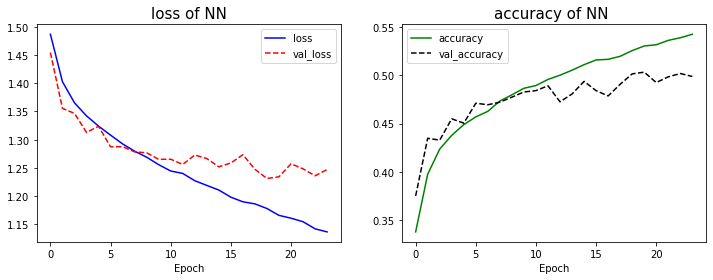

In [31]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of NN', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of NN ', fontsize= 15)
plt.plot(history.history['acc'], 'g-', label='accuracy')
plt.plot(history.history['val_acc'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

## NN은 학습이 잘 되지 않는것으로 보임
1. 모델과 데이터의 한계인듯

In [33]:
def BiLSTM():
    model = Sequential()
    model.add(Embedding(vocab_size, 300,weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(64,return_sequences= True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return(model)

# model summary
print(BiLSTM().summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 300, 300)          6000000   
                                                                 
 batch_normalization_11 (Bat  (None, 300, 300)         1200      
 chNormalization)                                                
                                                                 
 bidirectional_3 (Bidirectio  (None, 300, 128)         186880    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_25 (Dense)            (None, 5)                 325       
                                                     

In [35]:
p_val = np.zeros((train_padded.shape[0], n_class))
p_tst = np.zeros((test_padded.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, Y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = BiLSTM()    
    history2 = clf.fit(train_padded[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(Y_train[i_val])),
            epochs=30,
            batch_size=64,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

training model for CV #1
Epoch 1/30
572/572 [==============================] - 45s 68ms/step - loss: 1.2376 - acc: 0.5017 - val_loss: 1.0753 - val_acc: 0.5779
Epoch 2/30
572/572 [==============================] - 36s 63ms/step - loss: 0.8860 - acc: 0.6666 - val_loss: 0.9300 - val_acc: 0.6428
Epoch 3/30
572/572 [==============================] - 36s 63ms/step - loss: 0.6792 - acc: 0.7549 - val_loss: 0.8805 - val_acc: 0.6736
Epoch 4/30
572/572 [==============================] - 37s 64ms/step - loss: 0.5404 - acc: 0.8100 - val_loss: 0.8609 - val_acc: 0.6863
Epoch 5/30
572/572 [==============================] - 35s 61ms/step - loss: 0.4312 - acc: 0.8497 - val_loss: 0.9519 - val_acc: 0.6838
Epoch 6/30
572/572 [==============================] - 36s 63ms/step - loss: 0.3477 - acc: 0.8804 - val_loss: 0.9788 - val_acc: 0.6829
Epoch 7/30
572/572 [==============================] - 35s 62ms/step - loss: 0.2919 - acc: 0.9003 - val_loss: 1.0554 - val_acc: 0.6795
Epoch 8/30
572/572 [=================

In [36]:
print(f'Accuracy (CV): {accuracy_score(Y_train, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(Y_train), p_val):8.4f}')

Accuracy (CV):  67.8657%
Log Loss (CV):   0.8733


<function matplotlib.pyplot.show(*args, **kw)>

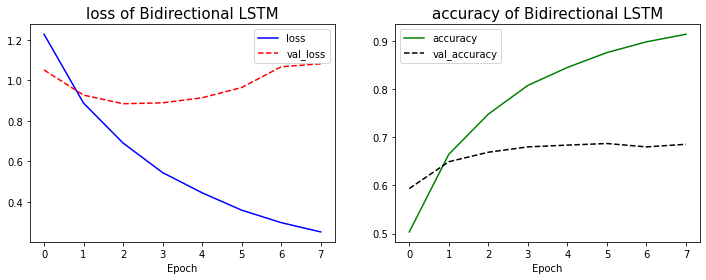

In [37]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM', fontsize= 15)
plt.plot(history2.history['loss'], 'b-', label='loss')
plt.plot(history2.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM', fontsize= 15)
plt.plot(history2.history['acc'], 'g-', label='accuracy')
plt.plot(history2.history['val_acc'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

### 사전학습 없이 한번 해보기

In [37]:
#파라미터 설정
vocab_size = 50000
embedding_dim = 100
max_length = 256
padding_type='post'

#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [40]:
def onlyEMB():
    model = Sequential()
    model.add(Embedding(vocab_size, 128))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return(model)

# model summary
print(onlyEMB().summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, None, 128)         6400000   
                                                                 
 global_average_pooling1d_20  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_32 (Dense)            (None, 5)                 645       
                                                                 
Total params: 6,400,645
Trainable params: 6,400,645
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
p_val = np.zeros((train_padded.shape[0], n_class))
p_tst = np.zeros((test_padded.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, Y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = BiLSTM2()    
    history3 = clf.fit(train_padded[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(Y_train[i_val])),
            epochs=50,
            batch_size=100,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

In [28]:
print(f'Accuracy (CV): {accuracy_score(Y_train, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(Y_train), p_val):8.4f}')

Accuracy (CV):  76.0856%
Log Loss (CV):   0.6631


<function matplotlib.pyplot.show(*args, **kw)>

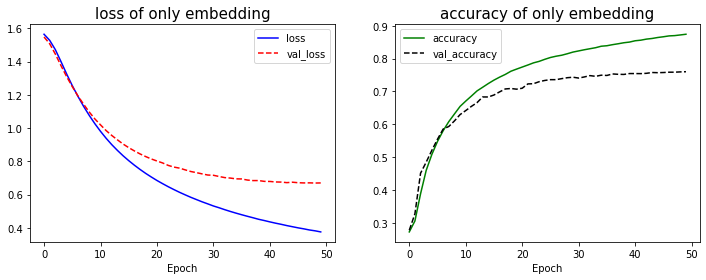

In [30]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of only embedding', fontsize= 15)
plt.plot(history3.history['loss'], 'b-', label='loss')
plt.plot(history3.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of only embedding', fontsize= 15)
plt.plot(history3.history['acc'], 'g-', label='accuracy')
plt.plot(history3.history['val_acc'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

## 임베딩층만 넣은 모델이 성능이 더 좋다... 왜 이런걸까